# Notebook 3: Exploratory Data Analytics

With deck and relic encodings complete, we'll step back and explore how the dataset **behaves**. The goal here is to build intuition about player behavior and model-relevant structure. We examine distributions of key variables (floor progression, HP, gold, deck size), look for class- and ascension-level patterns, and visualize how the deck embeddings evolve across a run.

This phase helps will help us catch anomalies, understand strategic trends across millions of runs, and guide the modeling choices that follow.

## Pandas Dataset Path Handlers

Lightweight shortcuts for loading preprocessed SVD parquet files into pandas.  
Use `DATASETS.C128.k1.load()` or `DATASETS.C64.full.load()` to access the desired dataset without hard-coding paths.

- `DATASETS`: the `namespace` object that holds all dataset handles.
- `.C128`: selects the 128-component SVD family (maps to `../128Component/`). *Alternatively use `.C64` to load the 64-component SVD family*
- `.k1`: picks the 1k-run slice within that family (loads `1k.parquet`). *Alternatively use `.k10` to load the 10k-run slice, and `.full` to load the full dataset*

`.load()` turns the formed path into a loaded pandas DataFrame from the parquet

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd

BASE_DIR = "/content/drive/MyDrive/STS-Win-Prediction/Datasets/SVD"

class _Dataset:
  def __init__(self, base_dir: str, dim: int, name: str):
    self.path = os.path.join(base_dir, f"{dim}Component", f"{name}.parquet")
  def load(self, columns=None) -> pd.DataFrame:
    """Load the dataset into a pandas DataFrame"""
    return pd.read_parquet(self.path, columns=columns)

class _Dim:
  def __init__(self, base_dir: str, dim: int):
    # aliases: k1 / _1k, k10 / _10k, full
    self.k1   = _Dataset(base_dir, dim, "1k")
    self._1k  = self.k1
    self.k10  = _Dataset(base_dir, dim, "10k")
    self._10k = self.k10
    self.full = _Dataset(base_dir, dim, "full")

class DATASETS:
  C64  = _Dim(BASE_DIR, 64)
  C128 = _Dim(BASE_DIR, 128)

In [3]:
# For EDA we'll load the complete model into a HIGH-ram colab compute runtime
df = DATASETS.C128.full.load()

In [ ]:
df.head(10)

,run_id,floor,victory,character,asc_level,deck_size,num_relics,max_hp,cur_hp,gold,...,deck_svd_118,deck_svd_119,deck_svd_120,deck_svd_121,deck_svd_122,deck_svd_123,deck_svd_124,deck_svd_125,deck_svd_126,deck_svd_127
0,18759847683600,0,False,IRONCLAD,0,11.0,1,72.0,72.0,114.0,...,0.005373,0.004568,0.043209,-0.019841,0.044052,-0.003375,0.008821,0.012429,-0.035523,0.029643
1,18759847683600,1,False,IRONCLAD,0,12.0,1,72.0,72.0,127.0,...,0.023894,0.011650,0.045542,-0.010784,0.036381,-0.003094,0.002893,0.010014,-0.029306,0.036024
2,18759847683600,2,False,IRONCLAD,0,13.0,1,72.0,72.0,127.0,...,0.028510,0.028210,0.034313,-0.010449,0.010496,-0.017408,0.000115,-0.008015,-0.007301,0.033082
3,18759847683600,3,False,IRONCLAD,0,14.0,2,72.0,72.0,127.0,...,0.021230,0.029339,0.025351,-0.014085,0.004469,-0.015599,-0.010306,-0.005257,-0.015817,0.034264
4,18759847683600,4,False,IRONCLAD,0,14.0,2,72.0,69.0,145.0,...,0.021230,0.029339,0.025351,-0.014085,0.004469,-0.015599,-0.010306,-0.005257,-0.015817,0.034264
5,18759847683600,5,False,IRONCLAD,0,15.0,2,72.0,49.0,177.0,...,0.025384,0.031180,0.020290,-0.003750,0.013815,-0.004680,-0.004003,0.008613,-0.013144,0.053839
6,18759847683600,6,False,IRONCLAD,0,15.0,3,72.0,49.0,177.0,...,0.025384,0.031180,0.020290,-0.003750,0.013815,-0.004680,-0.004003,0.008613,-0.013144,0.053839
7,18759847683600,7,False,IRONCLAD,0,15.0,3,72.0,52.0,193.0,...,0.094953,0.010739,0.073777,-0.124575,0.285490,0.011392,0.160518,0.071671,-0.096814,0.040254
8,18759847683600,8,False,IRONCLAD,0,16.0,3,72.0,52.0,193.0,...,0.113474,0.017822,0.076110,-0.115518,0.277819,0.011673,0.154590,0.069256,-0.090597,0.046635
9,18759847683600,9,False,IRONCLAD,0,16.0,4,72.0,42.0,223.0,...,0.113474,0.017822,0.076110,-0.115518,0.277819,0.011673,0.154590,0.069256,-0.090597,0.046635


## Basic EDA

We'll first being by gathering an understanding of what our dataset looks like. For example

- What is the average win percentage?
- How is our data distributed for certain floor counts?
- Can we find some basic features that appear highly correlated with win rates?

Namely, we aim to find our how informative the current floor is on victory likelihood

<Axes: xlabel='floor', ylabel='Count'>

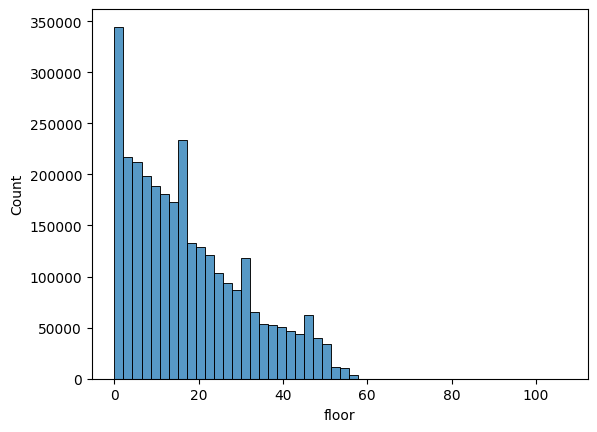

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histplot represents the general pattern of survival. We have fewer records for higher floor counts since every run
# is much more likely to have a floor 1, 2, 3 than a 40, 41, 42
sns.histplot(df['floor'], bins=50)

<Axes: xlabel='asc_level', ylabel='floor'>

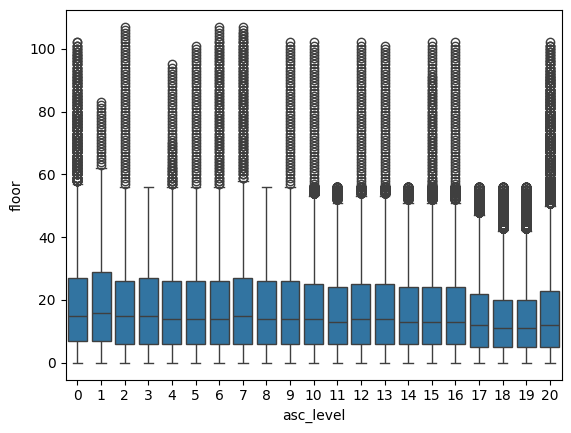

In [ ]:
# Floors are median distributed around 16 regardless of selected difficulty. This is exactly the first boss fight, so this makes sense as a logical first choke point
sns.boxplot(x='asc_level', y='floor', data=df)

<Axes: xlabel='count', ylabel='character'>

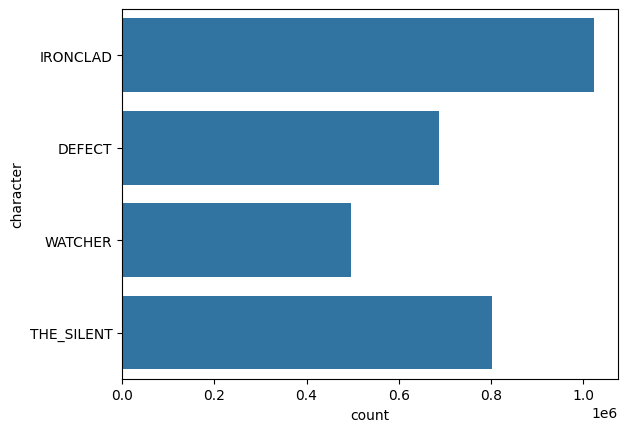

In [ ]:
# No unfortunate distributions by character class. We have at least 400k records for each class, so we should capture most playstyles
sns.countplot(df['character'])

### Victory Rate Analysis

In [ ]:
# Around 20% of our records are attached to a winning run. This should act as our baseline for model prediction
df['victory'].value_counts(normalize=True)

,proportion
victory,
False,0.79566
True,0.20434


Difficulty in Slay The Spire scales with a player's chosen Ascension Level, the impacts of this difficulty selection can be observed here

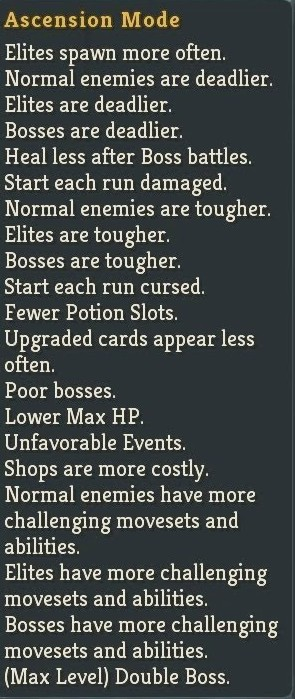

The community commonly agrees that levels 17, 18, and 19 are the highest difficulty bumps. Enemies, Elites, and Bosses all having more difficult movesets massively increases the game difficulty

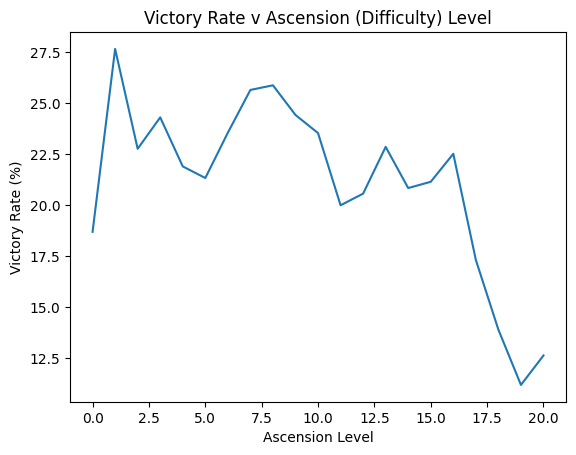

In [ ]:
# Victory rate actually increases for ASC 1, likely because players who have already beaten the game once are more likely to beat the game on a slightly
# higher difficulty than players who just picked up the game and struggle to get their first win.

# Win Rates exactly match with community anecdotes, with a massive dropoff after ascension 16 
victory_rate = df.groupby('asc_level')['victory'].mean().reset_index()
victory_rate['victory'] *= 100
sns.lineplot(data = victory_rate, x ='asc_level', y = 'victory')
plt.title("Victory Rate v Ascension (Difficulty) Level")
plt.xlabel("Ascension Level")
plt.ylabel("Victory Rate (%)")
plt.show()

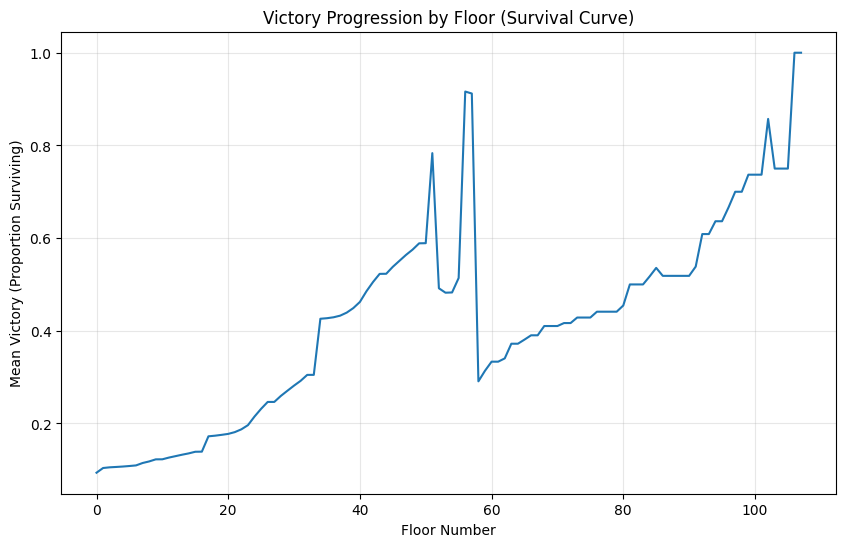

In [ ]:
# Compute "alive" proportion per floor (mean of victory == 1 across all runs that reached that floor)
survival = df.groupby('floor')['victory'].mean().reset_index()

# We can realisticall ignore rusn that are more than 45 runs, since they are in the inifintite or extended game modes.
plt.figure(figsize=(10, 6))
sns.lineplot(data=survival, x='floor', y='victory')
plt.title('Victory Progression by Floor (Survival Curve)')
plt.xlabel('Floor Number')
plt.ylabel('Mean Victory (Proportion Surviving)')
plt.grid(True, alpha=0.3)
plt.show()

<Axes: xlabel='floor', ylabel='hp_ratio'>

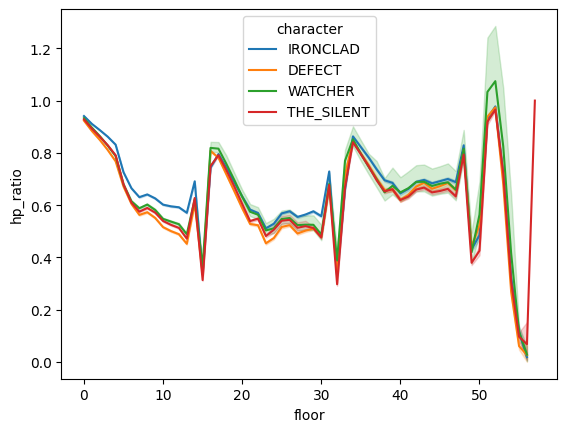

In [ ]:
# Interestlingly, player's average hp ratio seems to progress in very similar ways regardless of selected class
df['hp_ratio'] = df['cur_hp'] / df['max_hp']
sns.lineplot(x='floor', y='hp_ratio', hue='character', data=df)

## Correlations and Lasso Regression

What features are likely to be most useful for further modeling?

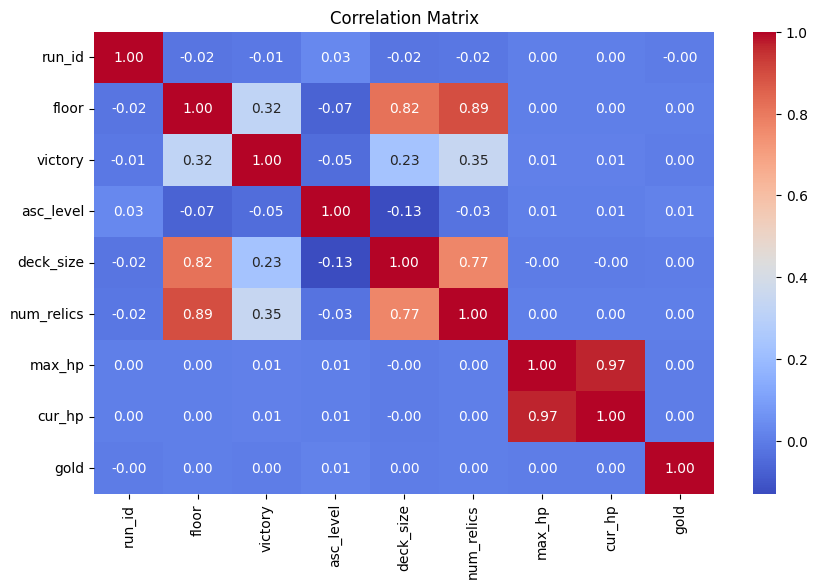

In [ ]:
# Generally, correlations with victory are low across the board, but collinearity is also low meaning our features could be independently informative
columns = ['run_id', 'floor', 'victory', 'character', 'asc_level', 'deck_size', 'num_relics', 'max_hp', 'cur_hp', 'gold']
corr = df[columns].corr(numeric_only = True)
plt.figure(figsize = (10,6))
sns.heatmap(corr, annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Correlation Matrix')
plt.show()

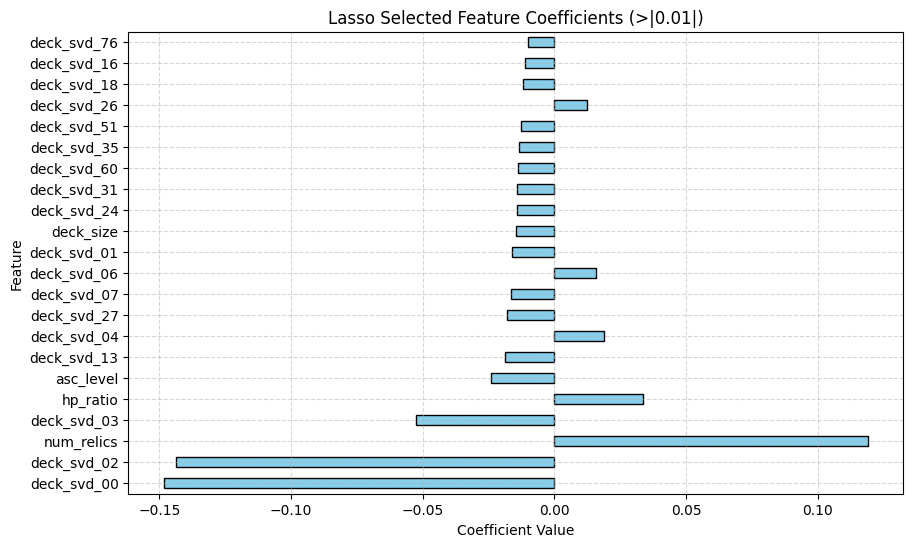

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LassoCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

y = df['victory']
X = df.drop(columns=['victory'])

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = ['character']
numeric_cols = [c for c in numeric_cols if c not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(drop='first'))
        ]), categorical_cols)
    ]
)

lasso_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('lasso', LassoCV(cv=5, random_state=42))
])

lasso_model.fit(X, y)

ohe_feature_names = (
    lasso_model.named_steps['preprocess']
    .named_transformers_['cat']
    .named_steps['ohe']
    .get_feature_names_out(categorical_cols)
)

feature_names = numeric_cols + list(ohe_feature_names)

coefficients = pd.Series(
    lasso_model.named_steps['lasso'].coef_,
    index=feature_names
)

selected_coefficients = coefficients[coefficients != 0].sort_values(key=abs, ascending=False)

threshold = 0.01
filtered_coefficients = selected_coefficients[abs(selected_coefficients) > threshold]

plt.figure(figsize=(10, 6))
filtered_coefficients.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Lasso Selected Feature Coefficients (>|0.01|)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.grid(linestyle='--', alpha=0.5)
plt.show()



## SVD Analysis

Our first pass with a simple Lasso model shows that several SVD components carry strong predictive signal.
Before relying on them in downstream models, we take a closer look:

- What do the components look like?
- How are they distributed across runs and floors?
- Do they capture recognizable deck evolution patterns?

This section explores those questions and helps us interpret the latent structure uncovered by the SVD.

In [39]:
svd_cols = [c for c in df.columns if c.startswith('deck_svd_')]

# Average by floor to see how decks evolve across progression
svd_floor = (
    df[df['floor'] <= 55]
    .groupby('floor')[svd_cols + ['victory']]
      .mean()
      .reset_index()
)


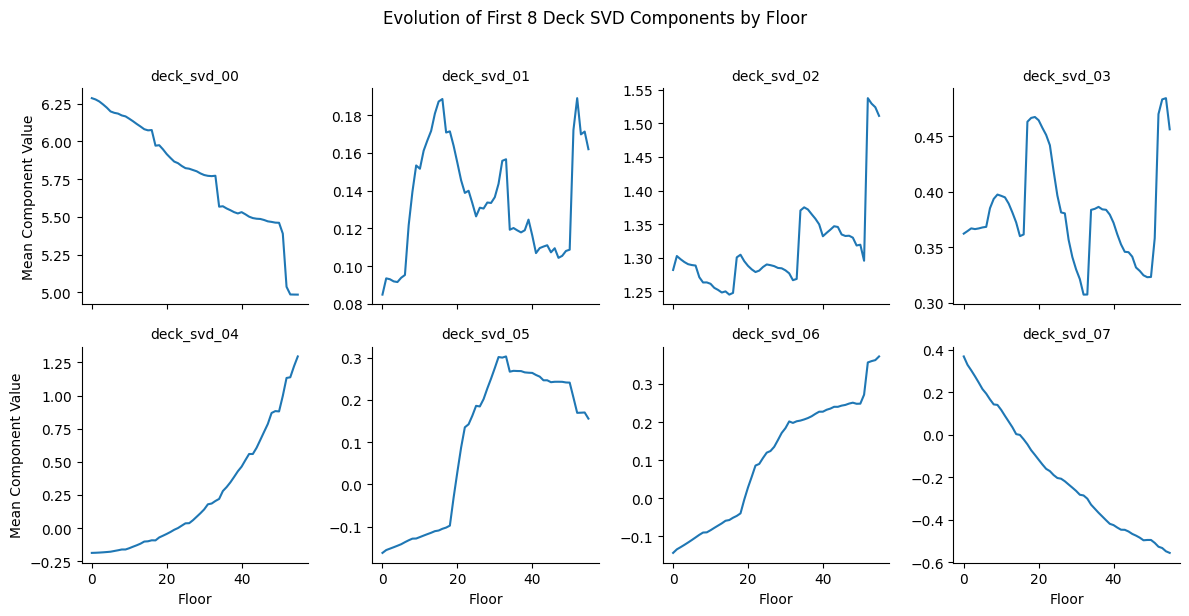

In [ ]:
# Long format for first 8 components
svd_long = svd_floor.melt(
    id_vars='floor',
    value_vars=svd_cols[:8],
    var_name='component',
    value_name='value'
)

# 2 rows, 4 columns (8 facets total)
g = sns.FacetGrid(
    svd_long,
    col='component',
    col_wrap=4,     # 4 columns -> 2 rows for 8 components
    sharex=True,
    sharey=False,
    height=3
)
g.map_dataframe(sns.lineplot, x='floor', y='value')
g.set_axis_labels("Floor", "Mean Component Value")
g.set_titles("{col_name}")

g.fig.suptitle("Evolution of First 8 Deck SVD Components by Floor", y=1.02)
plt.tight_layout()
plt.show()


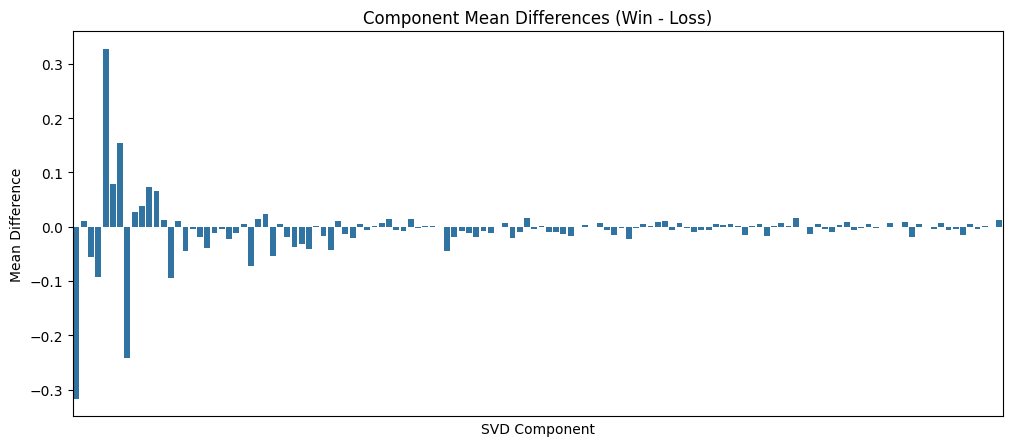

In [ ]:
# Compare latent coordinates between winning and losing runs
svd_victory = (
    df.groupby('victory')[svd_cols]
      .mean()
      .T
      .rename(columns={0:'loss',1:'win'})
)
svd_victory['diff'] = svd_victory['win'] - svd_victory['loss']

plt.figure(figsize=(12,5))
sns.barplot(x=svd_victory.index, y='diff', data=svd_victory)
plt.title('Component Mean Differences (Win - Loss)')
plt.xlabel('SVD Component')
plt.ylabel('Mean Difference')
plt.xticks([], [])
plt.show()


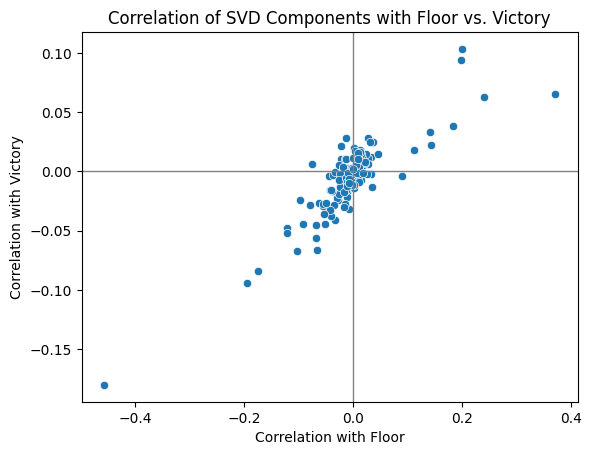

In [ ]:
# Interpretation: Components that positively correlate with floor and victory generally are viable win-predictors. Represent how strong a deck is
# Components that positively correlate with floor and negatively with victory are BAD pickups (e.g: Deck Clutter, Curses, etc)
# Components that negative correlate with floor and win-rate are likely indicators of starting deck behavior (Strikes, Defends, Class Starer Cards)
corrs = df[svd_cols + ['victory', 'floor']].corr()[['victory','floor']].iloc[:-2]
corrs.sort_values('victory', ascending=False).head(10)
sns.scatterplot(data=corrs, x='floor', y='victory')
plt.title('Correlation of SVD Components with Floor vs. Victory')
plt.xlabel('Correlation with Floor')
plt.ylabel('Correlation with Victory')
plt.axhline(0, color='gray', lw=1)
plt.axvline(0, color='gray', lw=1)
plt.show()


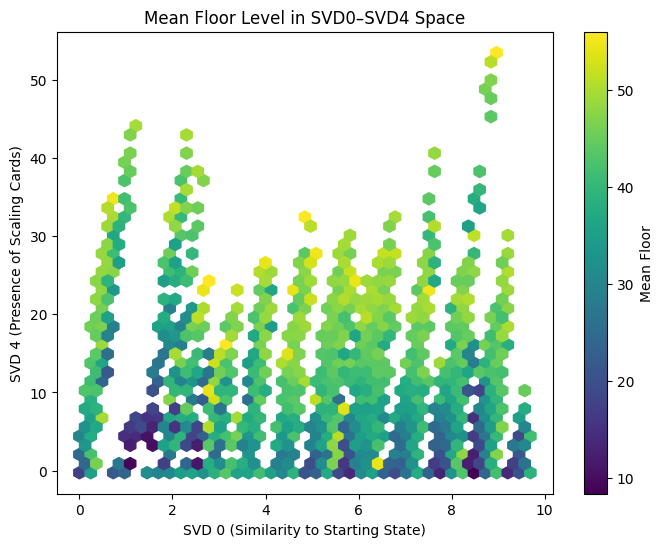

In [ ]:
# Awesome confirmation! Higher values of svd_04 (hypothesized deck power) strongly indicate how much a deck scales
plt.figure(figsize=(8,6))
hb = plt.hexbin(
    df['deck_svd_00'], df['deck_svd_04'],
    C=df['floor'], reduce_C_function=np.mean,
    gridsize=40, cmap='viridis'
)
plt.colorbar(hb, label='Mean Floor')
plt.xlabel('SVD 0 (Similarity to Starting State)')
plt.ylabel('SVD 4 (Presence of Scaling Cards)')
plt.title('Mean Floor Level in SVD0–SVD4 Space')
plt.show()


Importantly, can we use these features to make predictions that actually make sense over the course of a run?

In [47]:
X = df.drop(['run_id', 'deck_size', 'max_hp', 'cur_hp', 'gold', 'path_symbol', 'next_path_symbol', 'combat_damage', 'combat_turns', 'victory'], axis =1 ).select_dtypes(include = np.number)
y = df.victory

In [ ]:
# Fit a basic Logistic Regression on the data (not yet for actual evaluation)
from sklearn.linear_model import LogisticRegression
import numpy as np
model = LogisticRegression(max_iter = 1_000)
# This isn't a real model yet, so not bothering with train test split
model.fit(X, y)

LogisticRegression(max_iter=1000)

In [64]:
wins = df[(df.victory) & (df.run_id != 0)]
losses = df[~(df.victory) & (df.run_id != 0)]

winning_runs = wins.run_id.unique()
losing_runs = losses.run_id.unique()


TAKE_RUNS = 12
n = TAKE_RUNS // 2
example_runs = np.concatenate((winning_runs[:n], losing_runs[:n]))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def display_run_guess(df, run_id):
  """Plot a single run_id to make a graph"""
  run = df[df.run_id == run_id].copy()
  run_X = run[svd_cols]
  pred = model.predict_proba(run_X)[:, 0]
  run['pred'] = pred
  return sns.lineplot(run, x = 'floor', y = 'pred')

def display_run_guess_facet(df, run_ids, include_svd = True, model = model, col_wrap=3, sharey=True, sharex = True, height=2.0, aspect=1.0):
    """
    Plot model predictions over floor for one or more runs
    as a FacetGrid (one facet per run_id).
    """
    # Allow passing a single run_id or a list-like
    sns.set_style('darkgrid')
    if not isinstance(run_ids, (list, tuple, np.ndarray, pd.Series)):
        run_ids = [run_ids]

    runs = df[df["run_id"].isin(run_ids)].copy()
    if runs.empty:
        raise ValueError("No rows found for the given run_ids.")

    # Predict once for all selected rows
    X = runs\
      .drop(['run_id', 'deck_size', 'max_hp', 'cur_hp', 'gold', 'path_symbol', 'next_path_symbol', 'combat_damage', 'combat_turns', 'victory'], axis =1 )\
      .select_dtypes(include=np.number)

    if not include_svd:
      X.drop(svd_cols, axis = 1, inplace = True)
    runs["pred"] = model.predict_proba(X)[:, 1]
    # Sort run_ids by victory
    order = (
        runs.groupby("run_id")["victory"]
            .first()               # each run has a single victory value
            .sort_values()         # losing (0) -> winning (1)
            .index
            .tolist()
    )

    # Facet by run_id
    g = sns.relplot(
        data=runs,
        x="floor",
        y="pred",
        hue = 'victory',
        kind="line",
        col="run_id",
        col_wrap=col_wrap,
        col_order = order,
        height = height,
        aspect = aspect,
        facet_kws={"sharey": sharey, "sharex": sharex}
    )

    g.set(ylim = (0,1))
    g.set_axis_labels("Floor", "Predicted win prob")
    g.figure.suptitle("Run-level win probability trajectories", y=1.02)
    g.figure.subplots_adjust(top=0.95)  # make space for the title
    return g

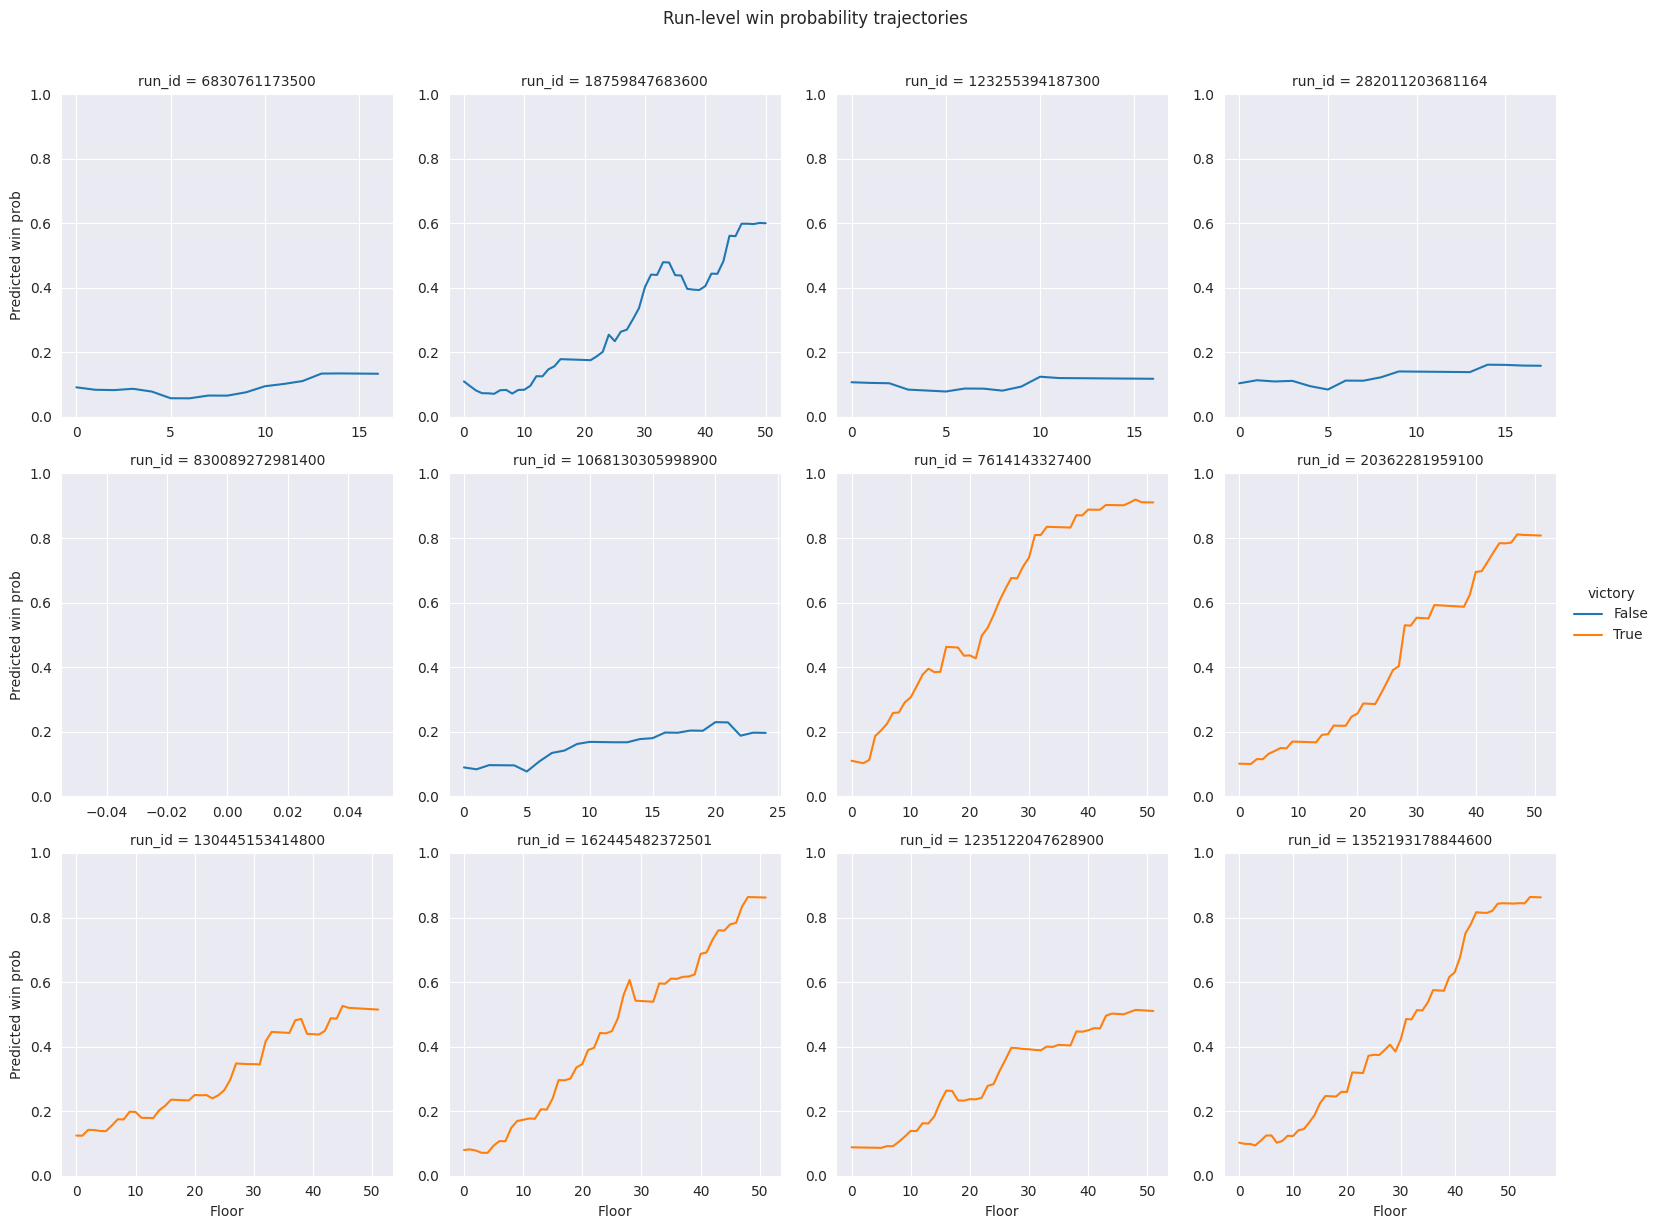

In [82]:
display_run_guess_facet(df, example_runs, col_wrap = 4, height = 4, sharex = False, sharey = False)
plt.show()

This is an **awesome** initial result! This is behaving exactly according to intuition: the model starts with extremely low certainty, and gradually builds it over the course of a good run!  

Specifcally, the losing models do not just increase their win certainty as their floor increases. Alongside, the winning models also do not just increase their probability to 1, some winning runs are weaker than others and their is captured by a relatively low certainty in the overall score


**Note** that without SVD or deck awareness it seems the model is generally much less certain and struggles al little more to distinguish between successful and failing runs

In [72]:
no_svd_model = LogisticRegression(max_iter = 1_000)
no_svd_model.fit(X.drop(svd_cols, axis=1), y)

LogisticRegression(max_iter=1000)

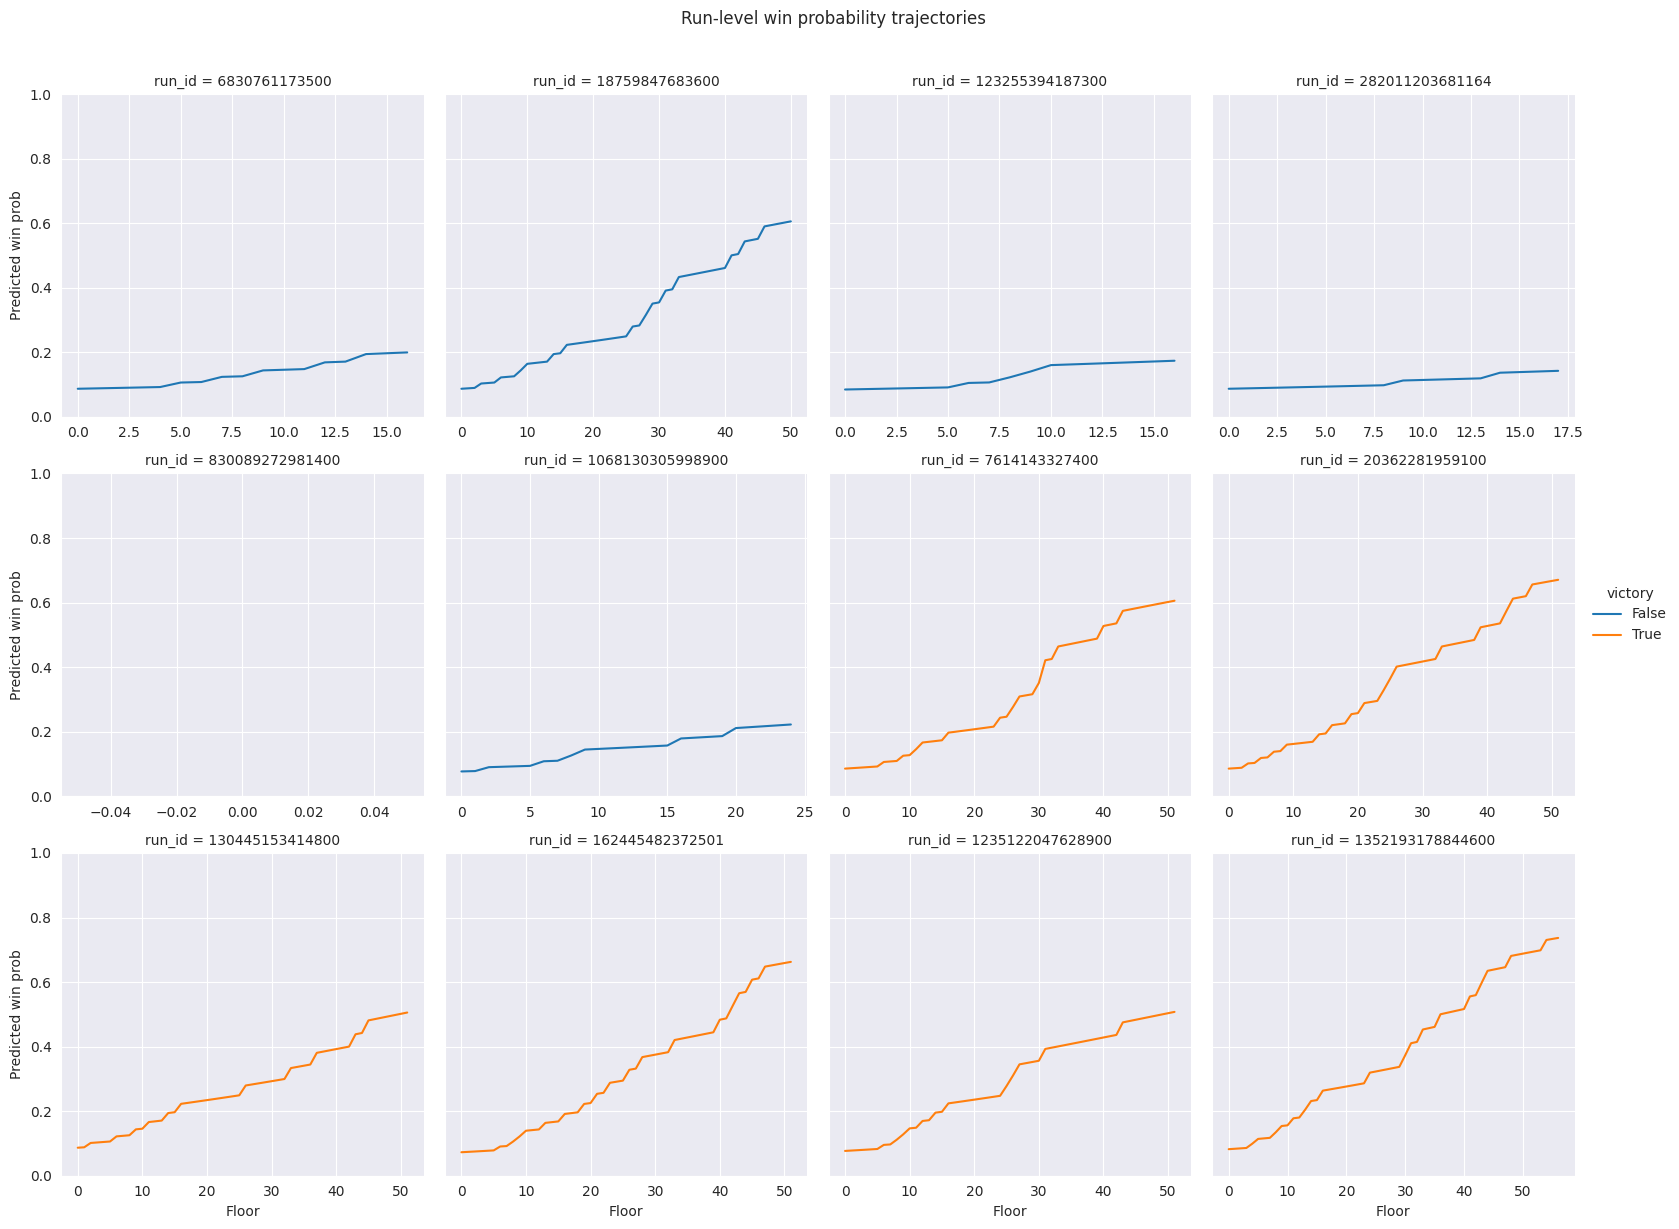

In [83]:
display_run_guess_facet(df, example_runs, include_svd = False, model = no_svd_model, col_wrap = 4, height = 4, sharex = False)
plt.show()

As is shown here, these results are for more homogenous and uninteresting, win probability is strictly tracked through number of relics and floors. The model is still accurate at the end but with a far reduced sense of certainty